# COMP 364: Sequence Handling with BioPython


## Warmup: OOP Practice

Write a class that representas a Student with two attributes: name, and grade. Next, write a class called Course that represents the students in the course with two initial attribute: course name, and a list of Students, a max capacity (class attribute). The Course class can also compute the average of all the students grades and add a student to the course.

In [ ]:
import statistics

class Student:
    def __init__(self, name, grade):
        self.name = name
        self.grade = grade
class Course:
    max_capacity = 3
    def __init__(self, name):
        self.course_name = name
        self.students = []
    def add_student(self, student_name, grade):
        if len(self.students) + 1 > Course.max_capacity:
            print("Class is full")
        else:
            self.students.append(Student(student_name, grade))
    def class_avg(self):
        return statistics.mean([s.grade for s in self.students])



c = Course("COMP 364")
print(c.course_name)
print(c.students)

c.add_student("Carlos", 3.4)
c.add_student("Chris", 4.0)
c.class_avg()

b = Course("COMP 202")
b.add_student("Carlos", 1.2)

print([student.name for student in b.students])
print([student.name for student in c.students])

# BioPython

BioPython is a very popular third party Python package for handling biological data.

In order to install:

```
conda install biopython
```

BioPython has three major functionalities:

* Sequence Handling
* 3D Structure
* Population Genetics

Today we'll cover sequence handling and next time we will do 3D structure handling, and if there is time we may do some Population Genetics.

Some useful references: [tutorial](http://biopython.org/DIST/docs/tutorial/Tutorial.html), [website](http://biopython.org/), [wiki](http://biopython.org/wiki/Category%3AWiki_Documentation) (most of my examples are coming from these sources).
 
# `BioPython.Seq`

The main object we'll be dealing with are sequences. This is handled by the `Seq` class.

As we know, we can have DNA, RNA, and Protein sequences.

BioPython helps us cleanly distinguish and do different things with different kinds of sequences.

In [ ]:
#let's make a generic sequence

from Bio.Seq import Seq

my_seq = Seq("CCCGGAGAGA")
print(type(my_seq))
#let's see what attributes this object has
attributes = [a for a in dir(my_seq) if not a.startswith("_")]
print(attributes)

It seems like there is a lot we can do with this object.

The problem is at this point Python doesn't know what kind of sequence this is (DNA, RNA, Protein).

We have to specify what kind of "Alphabet" the sequence belongs to.

In [ ]:
#right now it has just a generic alphabet
print(my_seq.alphabet)

In [ ]:
from Bio.Alphabet import generic_dna, generic_protein, generic_rna

my_dna = Seq("CCCGGAGAG", generic_dna)
my_rna = Seq("ACCCGUUGU", generic_rna)
my_protein = Seq("AKKKGGGUUULL", generic_protein)

Biopython will now know the difference for example between a DNA base `A` for adenine and the protein residue `A` for alanine.

Now we can do some cool things.

We can perform the main actions of the central dogma: transcribe and translate.

In [ ]:
my_gene = Seq("ACTAGCAGCGGA", generic_dna)

#get the mRNA

my_transcript = my_gene.transcribe()
print(my_transcript)
print(my_transcript.alphabet)


#get the protein from the mRNA
my_protein = my_transcript.translate()
print(my_protein)
print(my_protein.alphabet)

You can also go straight from the DNA to the protein.

In [ ]:
coding_dna = Seq("ATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAG", generic_dna)
myprot = coding_dna.translate()
print(myprot)

As you can see, we got some STOP codons represented as `*` and translation continued.

We can get translation to actually stop when it encounters a STOP codon.

In [ ]:
myprot = coding_dna.translate(to_stop=True)
print(myprot)

We can be even more realistic and only allow translation of valid genes (i.e. with a valid start and stop codon and proper number of bases).

This is done by setting the `cds=True` keyword argument, which stands for "coding sequence".

If we don't have a valid coding sequence, we get an exception.

In [ ]:
myprot = coding_dna.translate(cds=True)

In [ ]:
gene = Seq("ATGGCCATTGTAATGTAG", generic_dna)
gene.translate(cds=True)

### General sequence methods

There are some convenient operations for dealing with sequences.

We can concatenate sequences if they are of matching type.

In [ ]:
seq1 = Seq("AAACGGA", generic_dna)
seq2 = Seq("GGAGAT", generic_dna)

seq1 + seq2

We can also index and slice as though we had strings.

In [ ]:
seq1[:2] + seq2[-1]

`Seq` objects are immutable, just like strings.

In [ ]:
seq1[2] = "G"

There is another type of object called a `MutableSeq`. If we want to support mutability we can convert a `Seq` object to a `MutableSeq` object quite easily.

In [ ]:
mut_seq = seq1.tomutable()
mut_seq

In [ ]:
mut_seq[0] = "G"
print(mut_seq)

We can also do searching inside sequences.

In [ ]:
myseq = Seq("CCAGAAACCCGGAA", generic_dna)

#find the first occurence of the pattern
print(myseq.find("GAA"))

#find the number of non-overlapping occurrences of a pattern
print(myseq.count("GAA"))

# Database Searching

Say you isolated some piece of DNA in the lab and obtained its sequence.

You now want to find out which organism that sequence belongs to.

You ask a biologist and they tell you to just "BLAST it".

As you may know already, this is essentially the same as "Google it" for biologists.

BLAST is an alignment algorithm that searches for your sequence of interest in a huge database of sequences whose origins are known.

If you didn't know BioPython, you would take your sequence `AAAAGGAGAGAGAGTTTATA` and go to the [NCBI BLAST web server](https://blast.ncbi.nlm.nih.gov/Blast.cgi?PROGRAM=blastn&PAGE_TYPE=BlastSearch&LINK_LOC=blasthome) and click on buttons like a monkey.

Thanks to BioPython we can do this programatically!

The `qblast` method from the `Bio.Blast.NCBIWWW` module essentially sends our sequence to the BLAST web server.

Here we are using the "nucleotice BLAST" algorithm so we say `blastn` and we are using it on the database of all nucleotide sequences, called `nt`.


In [ ]:
from Bio.Blast import NCBIWWW

result_handle = NCBIWWW.qblast("blastn", "nt", Seq("AAAAGGAGAGAGAGTTTATA", generic_dna))

We wait a few seconds and get a `result_handle` which is like a temporary open file that we can read from.

The format of this file is in XML so not easy to read, thankfully BioPython has an XML parser that extracts all the information for us.

In [ ]:
from Bio.Blast import NCBIXML
blast_records = NCBIXML.parse(result_handle)

We get an "iterator" of BLAST record objects, or "search results". We can now loop over each of our search results and print some information.

Here I am looping over all the results which each have an attribute `alignments` which are the alignments of our query sequence to some organism in the database.

The `alignment` attribute itself has other attributes like the `query` sequence, the `length` and `title` of the matching organism..

In [ ]:
for b in blast_records:
    for alignment in b.alignments:
        for hsp in alignment.hsps:
            print('****Alignment****')
            print('sequence:', alignment.title)
            print('length:', alignment.length)
            print('e value:', hsp.expect)
            print(hsp.query[0:75] + '...')
            print(hsp.match[0:75] + '...')
            print(hsp.sbjct[0:75] + '...')

# `SeqRecord` and `SeqIO`

Often, sequences have some additional information associated to them. 

A good example was the BLAST exercise which gave us sequences associated to specific organisms, and genomic locations.

Ideally we would want to be able to keep this information along with our `Seq` if we have it.

BioPython lets us do this with the `SeqRecord` and `SeqIO` classes.


## Parsing with `SeqIO`

The `SeqIO` class which stands for Sequence Input/Output lets us read and write from various sequence annotation file formats which are common in biological databases.

I went to the [GenBank](https://www.ncbi.nlm.nih.gov/genbank/) sequence database and looked for some sequence related to the Bubonic Plague (Yersinia Pestis bacteria) [here](https://www.ncbi.nlm.nih.gov/nuccore/NZ_ADRZ01000932.1?report=fasta).

![](https://www.nationalgeographic.com/content/dam/science/photos/000/033/3338.ngsversion.1492437604403.adapt.676.1.jpg)
("The Triumph of Death by  Pieter Bruegel)

We get a `fasta` file which is very common for sequence annotations so BioPython can parse it for us automatically.

The annotation for a FASTA sequence is typically held in the header:

```
>NZ_ADRZ01000932.1 Yersinia pestis biovar Antiqua str. E1979001 Contig_E1979001_19275, whole genome shotgun sequence
```

The `SeqIO.parse` takes a path to a file and a format, in this case "fasta" and produces an iteratror over each entry in the fasta file.

Each item produced by the iterator is a `SeqRecords` object.


In [4]:
from Bio import SeqIO

records = SeqIO.parse("plague.fa", "fasta")
for r in records:
    print(type(r))
    print([a for a in dir(r) if not a.startswith("_")])

<class 'Bio.SeqRecord.SeqRecord'>
['annotations', 'dbxrefs', 'description', 'features', 'format', 'id', 'letter_annotations', 'lower', 'name', 'reverse_complement', 'seq', 'upper']
<class 'Bio.SeqRecord.SeqRecord'>
['annotations', 'dbxrefs', 'description', 'features', 'format', 'id', 'letter_annotations', 'lower', 'name', 'reverse_complement', 'seq', 'upper']


### `SeqRecord` Objects

If you have a file with a single fasta record, you can use the `SeqIO.read()` function.


In [5]:
record = SeqIO.read("single_plague.fa", "fasta")

The `SeqRecords` object has some useful attributes.

The object contains a `Seq` object witih the sequence info.

In [6]:
print(record)

ID: NZ_ADRZ01000932.1
Name: NZ_ADRZ01000932.1
Description: NZ_ADRZ01000932.1 Yersinia pestis biovar Antiqua str. E1979001 Contig_E1979001_19275, whole genome shotgun sequence
Number of features: 0
Seq('CTCTCCCAGCTGAGCTATAGCCCCAATGCGCACATAATAAATCGTGTGAACGGG...AGC', SingleLetterAlphabet())


In [7]:
print(record.seq)

CTCTCCCAGCTGAGCTATAGCCCCAATGCGCACATAATAAATCGTGTGAACGGGGCGCATGATATGAGACCCCCGAAACTGTGTCAACGGCTAAATCGATTTCTCGTGTTAAGCGCTGAAAAAGCGGCCAAATCAGCCTGCAAATAACATAATAAGTGGAATGATGTTCACAAATTTGTTGTCACACCGCTGCTGTTATCAAATATAATAAATATCCTCCGGCATAGC


In [8]:
print(record.id)

NZ_ADRZ01000932.1


In [9]:
print(record.description)

NZ_ADRZ01000932.1 Yersinia pestis biovar Antiqua str. E1979001 Contig_E1979001_19275, whole genome shotgun sequence


We can also create our own `SeqRecord` objects.

In [10]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
record = SeqRecord(Seq("MKQHKAMIVALIVICITAVVAALVTRKDLCEVHIRTGQTEVAVF",
                       IUPAC.protein),
                   id="YP_025292.1", name="HokC",
                   description="toxic membrane protein, small")
print(record)

ID: YP_025292.1
Name: HokC
Description: toxic membrane protein, small
Number of features: 0
Seq('MKQHKAMIVALIVICITAVVAALVTRKDLCEVHIRTGQTEVAVF', IUPACProtein())


Then we can write it to FASTA format.

In [11]:
record.format("fasta")

'>YP_025292.1 toxic membrane protein, small\nMKQHKAMIVALIVICITAVVAALVTRKDLCEVHIRTGQTEVAVF\n'

And then store it in a file. 

So now we know how to read sequence information, as well as produce our own sequence records and store them.

In [12]:
with open("myfasta.fa", "w") as f:
    f.write(record.format("fasta"))
    

## Making Multiple Sequence Alignments and Phylogenetic Trees

Another thing biologists like to do is align (essentially, compare) sequences.

If we line up two sequences on top of each other, we can look at the parts where they are different and infer many useful pieces of information.

One of these pieces of information is the phylogeny.

i.e. we can take a guess at how evolution took place to explain a particular set of observed sequences.



### Step 1: Obtain some sequences and align them

In [13]:
import random

#generate some random sequences based on a random seed sequence
mut = 0.1
BASES = {"A", "C", "G", "T"}
seqs = []
seed = "".join([random.choice(list(BASES)) for _ in range(25 + random.choice([-1, 0, 1]))])

seq_records = []

for i in range(20):
    new_seq = "".join([b if random.random() > mut else random.choice(list(BASES - {b}))\
        for b in seed])
    #create a seq record
    seq_records.append(SeqRecord(Seq(new_seq), id=str(i)))
    
print(seq_records)

[SeqRecord(seq=Seq('AACCGTCAGAAGAGAGCTTTATGCAC', Alphabet()), id='0', name='<unknown name>', description='<unknown description>', dbxrefs=[]), SeqRecord(seq=Seq('ATCCGTCAGGATAGAGTTTTATTCTC', Alphabet()), id='1', name='<unknown name>', description='<unknown description>', dbxrefs=[]), SeqRecord(seq=Seq('AACCGTCCGAATCGAGCATTATTCTC', Alphabet()), id='2', name='<unknown name>', description='<unknown description>', dbxrefs=[]), SeqRecord(seq=Seq('AACCGTCCGAATAGCCCTTTATTCTC', Alphabet()), id='3', name='<unknown name>', description='<unknown description>', dbxrefs=[]), SeqRecord(seq=Seq('ATCGGTACGAATAGAGCTTTATTCTC', Alphabet()), id='4', name='<unknown name>', description='<unknown description>', dbxrefs=[]), SeqRecord(seq=Seq('AACCGTCGGAAAAGAGCTTTAGTCTC', Alphabet()), id='5', name='<unknown name>', description='<unknown description>', dbxrefs=[]), SeqRecord(seq=Seq('AACCGTCCGTGTACAGCTTTATTCGG', Alphabet()), id='6', name='<unknown name>', description='<unknown description>', dbxrefs=[]), SeqRe

Now that we have `SeqRecord` objects we can align them.

To do so, we need to put them in a `fasta` file.

### Step 2: Align the sequences

In [14]:
#write our sequences to fasta format
with open("seqs.fasta", "w") as f:
    SeqIO.write(seq_records, f, "fasta")

The next step is to actually align these sequences.

BioPython has its own alignment functionalities but it requires some more installations.

So let's just use an [online tool](https://www.ebi.ac.uk/Tools/msa/muscle/) which takes a input a `fasta` file which we just created.

### Step 3: Load the resulting alignment

In [15]:
#open the alignmnent file
from Bio import AlignIO
with open("aln.clustal", "r") as aln:
    #use AlignIO to read the alignment file in 'clustal' format
    alignment = AlignIO.read(aln, "clustal")

We can parse the alignment with the `AlignIO` module from BioPython.

I won't go into detail on this module but it has a lot of useful funcionality for dealing with sequence alignments.


### Step 4: Use the alignment to obtain a "distance" between all pairs of sequences

Using the parsed alignment, we can get the distance (or difference) between all the sequences.

This just tells us, for each pair of sequences, how different they are.

In [16]:
from Bio.Phylo.TreeConstruction import DistanceCalculator

#calculate the distance matrix
calculator = DistanceCalculator('identity')
#adds distance matrix to the calculator object and returns it
dm = calculator.get_distance(alignment)
print(dm)

18	0
4	0.36	0
7	0.36	0.24	0
16	0.31999999999999995	0.28	0.24	0
15	0.24	0.31999999999999995	0.31999999999999995	0.28	0
12	0.31999999999999995	0.31999999999999995	0.31999999999999995	0.28	0.31999999999999995	0
14	0.31999999999999995	0.24	0.24	0.24	0.28	0.28	0
0	0.31999999999999995	0.28	0.28	0.24	0.28	0.24	0.19999999999999996	0
3	0.28	0.24	0.24	0.19999999999999996	0.24	0.24	0.16000000000000003	0.040000000000000036	0
11	0.28	0.24	0.24	0.16000000000000003	0.19999999999999996	0.24	0.19999999999999996	0.19999999999999996	0.16000000000000003	0
17	0.19999999999999996	0.24	0.24	0.19999999999999996	0.24	0.24	0.19999999999999996	0.19999999999999996	0.16000000000000003	0.16000000000000003	0
19	0.24	0.19999999999999996	0.19999999999999996	0.16000000000000003	0.19999999999999996	0.19999999999999996	0.16000000000000003	0.16000000000000003	0.12	0.12	0.12	0
6	0.16000000000000003	0.19999999999999996	0.19999999999999996	0.16000000000000003	0.12	0.19999999999999996	0.16000000000000003	0.16000000000000003	0

### Step 5: Construct a tree from the set of distances

And finally, we can construct a phylogenetic tree from the pairwise distances between all the sequences.

In [18]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor

#initialize a DistanceTreeConstructor object based on our distance calculator object
constructor = DistanceTreeConstructor(calculator)

#build the tree
upgma_tree = constructor.build_tree(alignment)

And let's use the `Phylo` module to visualize the result!

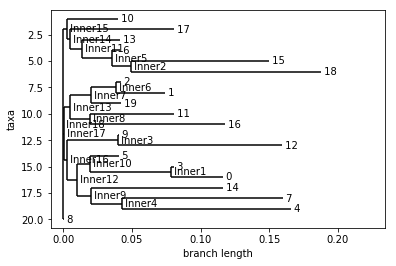

In [19]:
from Bio import Phylo
import pylab
#draw the tree
Phylo.draw(upgma_tree)